In [5]:
from typing import Optional, List, Tuple
from collections import Counter

import matplotlib.pyplot as plt
import pandas as pd
import numpy as np

import nltk
nltk.download('stopwords')
nltk.download('punkt')
from nltk.corpus import stopwords

from sklearn.feature_extraction.text import CountVectorizer, TfidfVectorizer
from sklearn.ensemble import ExtraTreesRegressor, RandomForestRegressor
from sklearn.decomposition import PCA
from sklearn.decomposition import TruncatedSVD
from sklearn.model_selection import train_test_split
from scipy import stats

# Comment those lines if you're on a MAC and the installation does not work!
from lightgbm import LGBMRegressor
from lazypredict.Supervised import LazyRegressor

from sentence_transformers import InputExample
from sklearn.model_selection import train_test_split
from sentence_transformers.cross_encoder import CrossEncoder
from sentence_transformers.cross_encoder.evaluation import CECorrelationEvaluator

from torch.utils.data import DataLoader

[nltk_data] Downloading package stopwords to
[nltk_data]     /Users/nicolai/nltk_data...
[nltk_data]   Package stopwords is already up-to-date!
[nltk_data] Downloading package punkt to /Users/nicolai/nltk_data...
[nltk_data]   Package punkt is already up-to-date!


# Preprocessing

In [17]:
csv_path = "data/correct_cols.tsv"

In [18]:
def add_missing_tabs_in_file(source_path: str, target_path: str) -> None:
    with open(source_path, "r") as source, open(target_path, "w") as target:
        headers = "file\tyear\tid\tscore\tsen1\tsen2\tinfo1\tinfo2\n"
        target.write(headers)
        for line in source:
            if line.count("\t") == 5:
                line = line.strip()
                line += "\t\t\n"
            target.write(line)
add_missing_tabs_in_file("data/sts-other.tsv", csv_path)

In [19]:
df = pd.read_csv(csv_path, sep="\t")

In [20]:
def summarise(df: pd.DataFrame, columns: Optional[List[str]] = None) -> str:
    """
    Retrieves statistical information of every column of the provided dataframe.
    To summarise only selected columns, provide the columns names.
    :param df: dataframe to summarise.
    :param columns: optional list of column names to summarise specific columns.
    :return: printable string containing summary statistics.
    """
    if columns:
        df = df[:, columns]
    s = f"Summary statistics:\nDataframe dimensions: {len(df)}x{len(df.columns)}"
    for i in range(len(df.columns)):
        col = df.iloc[:, i]
        t = str(col.dtype)
        s += f"\n{col.name} - {t}"
        if t == "bool" or ((col == 0) | (col == 1)).all():
            col = col.astype("bool")
            counts = col.value_counts()
            s += f"\n\tCounts:"
            s += f"\n\t\tTrue: {counts[0]}"
            s += f"\n\t\tFalse: {counts[1]}"
        elif t in {"float64", "int64"}:
            s += f"\n\tRange({np.nanmin(col): .2f}, {np.nanmax(col): .2f})"
            col_q = col.quantile((.25, .5, .75)).values
            s += f"\n\tQuantiles: 0.25: {col_q[0]: 0.2f} | 0.5: {col_q[1]: 0.2f} | 0.75: {col_q[2]: 0.2f}"
            s += f"\n\tMean: {np.nanmean(col): .2f}"
        else:
            s += f"\n\tExamples:"
            for idx in range(3):
                s += f"\n\t\t{col[idx]}"
            s += f"\n\tUnique objects:"
            s += f"\n\t\t{len(col.unique())}"
        s += f"\n\tContains NaN: {pd.isna(col).any()}"
    return s

print(summarise(df))

Summary statistics:
Dataframe dimensions: 3814x8
file - object
	Examples:
		surprise.OnWN
		surprise.OnWN
		surprise.OnWN
	Unique objects:
		7
	Contains NaN: False
year - object
	Examples:
		2012test
		2012test
		2012test
	Unique objects:
		5
	Contains NaN: False
id - int64
	Range( 0.00,  1981.00)
	Quantiles: 0.25:  161.00 | 0.5:  359.50 | 0.75:  574.00
	Mean:  419.43
	Contains NaN: False
score - float64
	Range( 0.00,  5.00)
	Quantiles: 0.25:  1.00 | 0.5:  3.20 | 0.75:  4.20
	Mean:  2.73
	Contains NaN: False
sen1 - object
	Examples:
		render one language in another language
		nations unified by shared interests, history or institutions
		convert into absorbable substances, (as if) with heat or chemical process
	Unique objects:
		3142
	Contains NaN: False
sen2 - object
	Examples:
		restate (words) from one language into another language.
		a group of nations having common interests.
		soften or disintegrate by means of chemical action, heat, or moisture.
	Unique objects:
		2936
	Contain

In [21]:
df["year"] = df.year.str.replace("test", "")
df = (df
      .astype({"file": "category", "year": "int16"})
      .drop("id", axis=1)
      .fillna("")
)
df.to_feather("data/preprocessed.feather")

In [9]:
print(summarise(df))

Summary statistics:
Dataframe dimensions: 3814x7
file - category
	Examples:
		surprise.OnWN
		surprise.OnWN
		surprise.OnWN
	Unique objects:
		7
	Contains NaN: False
year - int16
	Examples:
		2012
		2012
		2012
	Unique objects:
		5
	Contains NaN: False
score - float64
	Range( 0.00,  5.00)
	Quantiles: 0.25:  1.00 | 0.5:  3.20 | 0.75:  4.20
	Mean:  2.73
	Contains NaN: False
sen1 - object
	Examples:
		render one language in another language
		nations unified by shared interests, history or institutions
		convert into absorbable substances, (as if) with heat or chemical process
	Unique objects:
		3142
	Contains NaN: False
sen2 - object
	Examples:
		restate (words) from one language into another language.
		a group of nations having common interests.
		soften or disintegrate by means of chemical action, heat, or moisture.
	Unique objects:
		2936
	Contains NaN: False
info1 - object
	Examples:
		nan
		nan
		nan
	Unique objects:
		232
	Contains NaN: True
info2 - object
	Examples:
		nan
		nan
	

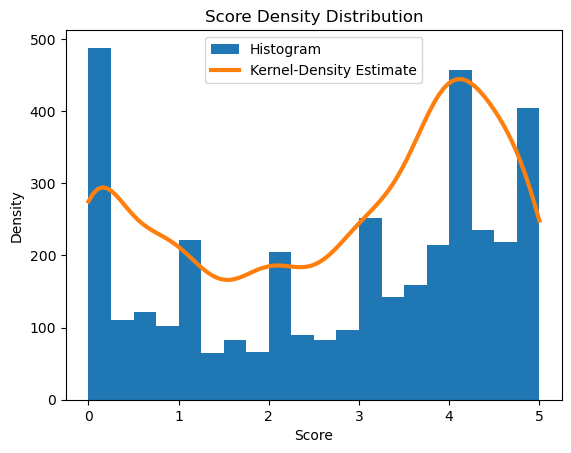

In [10]:
plt.hist(df.score, bins=20, label="Histogram")
xs = np.linspace(0, 5, 100)
kde = stats.gaussian_kde(df.score)
plt.plot(
    xs, [kde(x)*len(df.score)/2.5 for x in xs],
    label="Kernel-Density Estimate", linewidth=3)
plt.title("Score Density Distribution")
plt.xlabel("Score")
plt.ylabel("Density")
plt.legend()
plt.show()

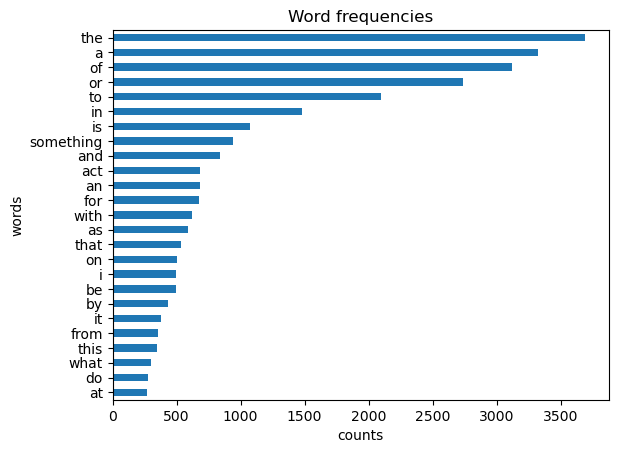

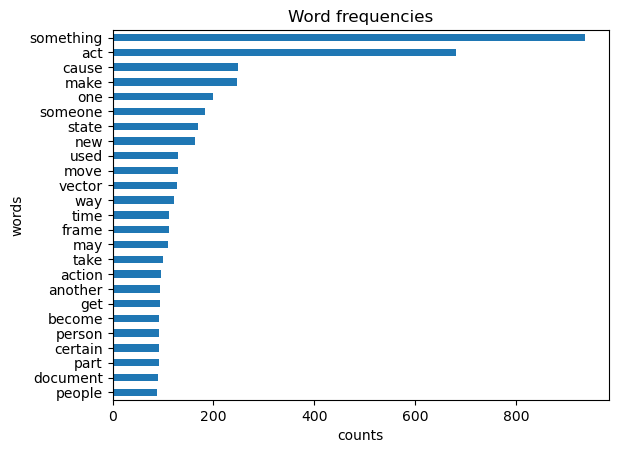

In [11]:
def plot_top_k_word_freq(sentences: List[str], k: int, remove_stopwords: bool = False, title_addon: str = ""):
    eng_stopwords = stopwords.words("english")
    # count each word
    cnt = Counter()
    for sentence in sentences:
        for word in nltk.word_tokenize(sentence):
            if word.isalpha() and (not remove_stopwords or word.lower() not in eng_stopwords):
                cnt[word.lower()] += 1

    # plot words frequencies
    (
        pd.DataFrame(cnt.most_common(k), columns=["words", "counts"])
        .sort_values(by="counts")
        .plot.barh(x="words", y="counts", legend=None)
    )
    plt.title("Word frequencies" + title_addon)
    plt.xlabel("counts")
    plt.show()

all_sentences = pd.concat([df.sen1, df.sen2]).to_list()

plot_top_k_word_freq(all_sentences, k=25)
plot_top_k_word_freq(all_sentences, k=25, remove_stopwords=True)

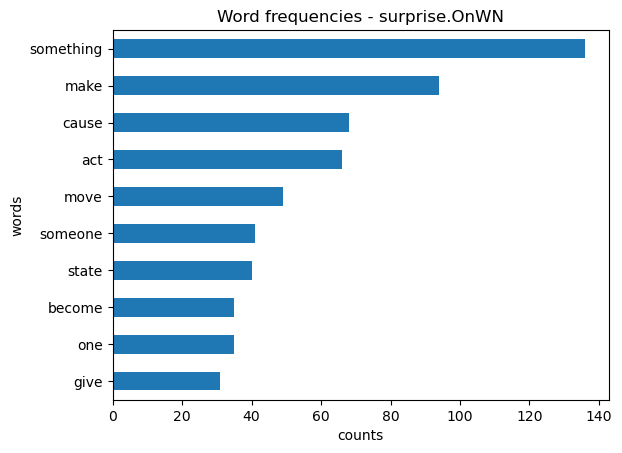

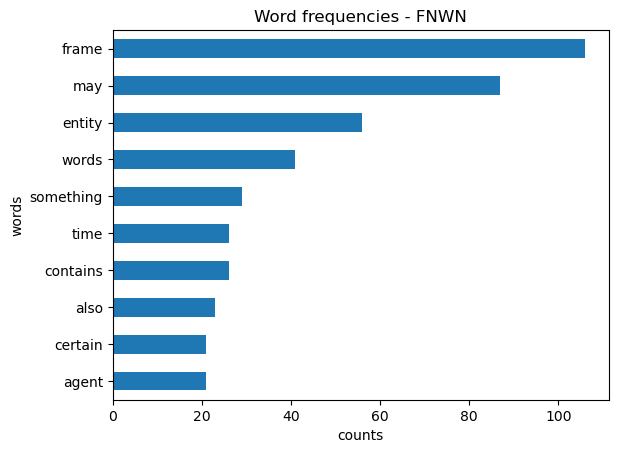

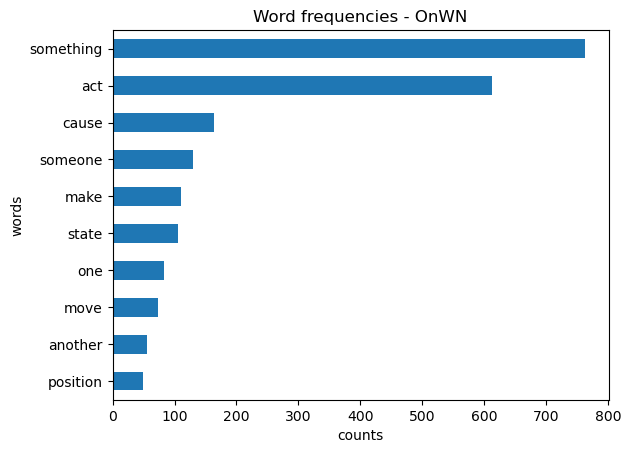

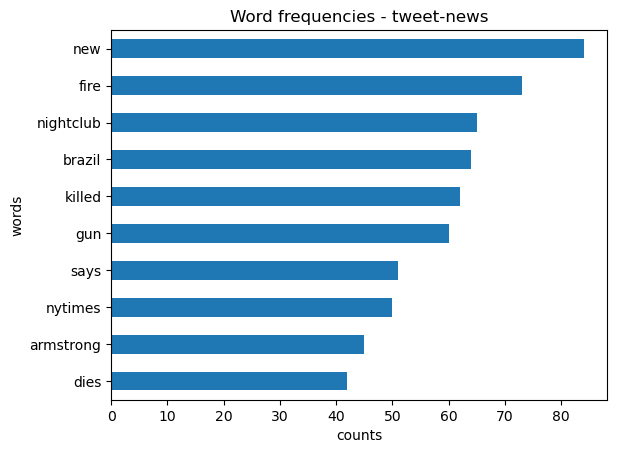

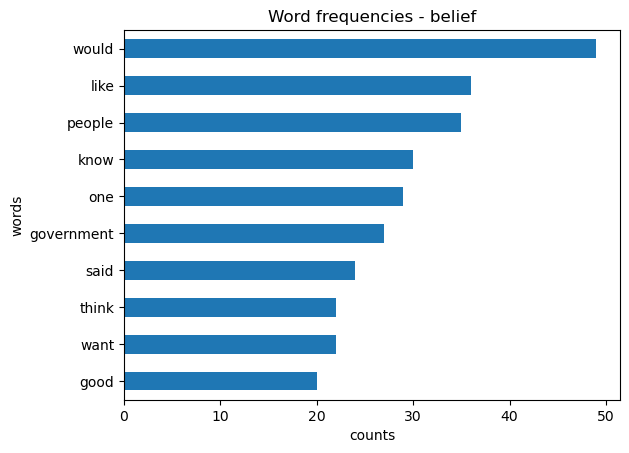

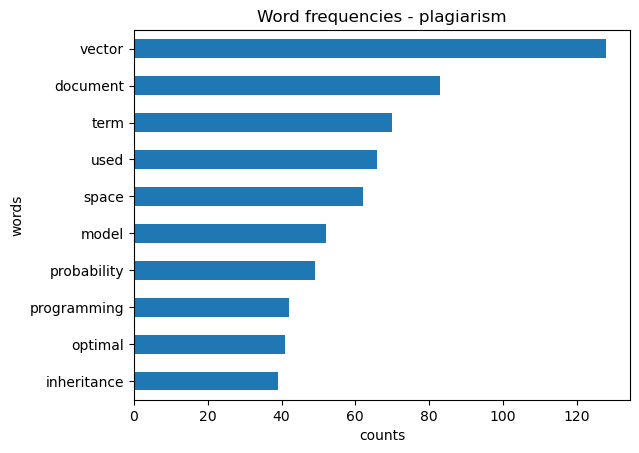

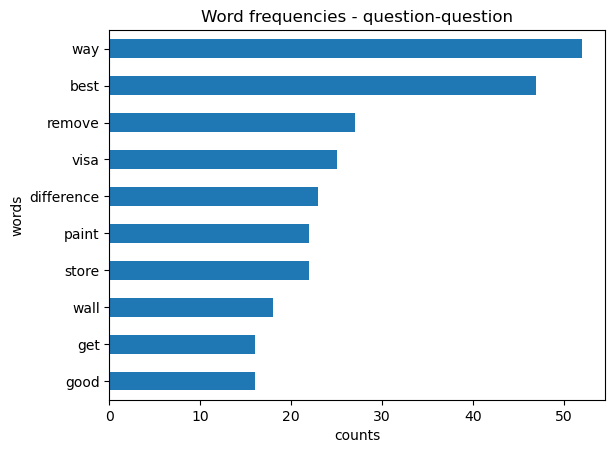

In [12]:
# Plot wordcounts for each category
for u in df.file.unique():
    category = df.file == u
    sentences = pd.concat([df.sen1[category], df.sen2[category]]).to_list()
    plot_top_k_word_freq(sentences, k=10, remove_stopwords=True, title_addon=f" - {u}")

# Statistical Analysis

In [22]:
text = df[['sen1', 'sen2', 'info1', 'info2']].values
# text = df[['sen1', 'sen2']].values
flattened_list = text.flatten()

vectorizer = TfidfVectorizer()

vocabulary = vectorizer.fit_transform(flattened_list)
vocabulary = vocabulary.toarray()

vocabulary.shape

(15256, 9920)

In [23]:
# centered_vocabulary = vocabulary - np.mean(vocabulary, axis=0)
# pca = PCA(n_components=1000)
# components = pca.fit_transform(centered_vocabulary)

Tsvd = TruncatedSVD(n_components=1100)
truncated = Tsvd.fit_transform(vocabulary)
truncated.shape

(15256, 1100)

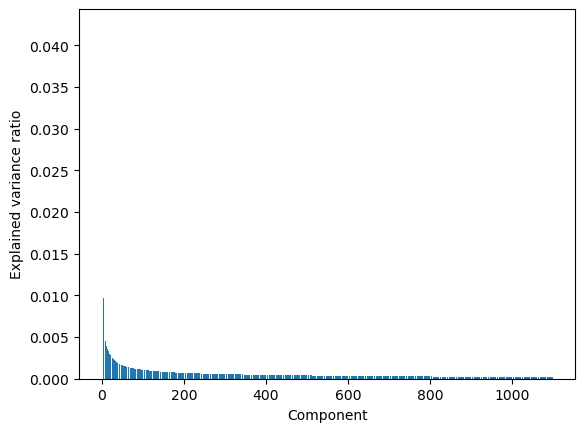

In [24]:
plt.bar(range(len(Tsvd.explained_variance_ratio_)), Tsvd.explained_variance_ratio_)
plt.xlabel('Component')
plt.ylabel('Explained variance ratio')
plt.show()

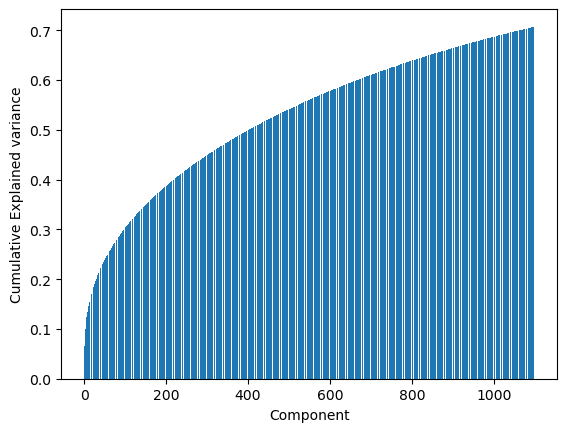

In [25]:
plt.bar(range(len(Tsvd.explained_variance_ratio_)), np.cumsum(Tsvd.explained_variance_ratio_))
plt.xlabel('Component')
plt.ylabel('Cumulative Explained variance')
plt.show()

In [26]:
y = df['score'].values

X_set = truncated

X = [np.concatenate([X_set[i], X_set[i+1], X_set[i+2], X_set[i+3]]) for i in range(0,len(X_set),4)]
X = np.array(X)

X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.1, random_state=0)

In [27]:
X.shape

(3814, 4400)

Use the lazy regressor to test a variety of regressors in one go and choose a selection of the results

In [28]:
# exclude = ['QuantileRegressor']

# metric = stats.pearsonr

# reg = LazyRegressor(verbose=0, ignore_warnings=False, custom_metric=metric)
# models,predictions = reg.fit(X_train, X_test, y_train, y_test)
# models

In [29]:
n_trees = 250

(use the extra tree if lightgbm installation didn't work on MAC)

In [ ]:
# Extra Trees (use this if you're on a MAC)
# extra_trees = ExtraTreesRegressor(n_estimators=n_trees, random_state=0)
# extra_trees.fit(X_train, y_train)
# et_predictions = extra_trees.predict(X_test)
# print("Extra Trees Regressor Pearson score:", stats.pearsonr(y_test, et_predictions))

In [ ]:
# Light GBM
lightGBM = LGBMRegressor(n_estimators=n_trees, random_state=0)
lightGBM.fit(X_train, y_train)

lgbm_predictions = lightGBM.predict(X_test)
print("Light-GMB Pearson score:", stats.pearsonr(y_test, lgbm_predictions))

## Evaluation

In [ ]:
# lgbm_predictions = extra_trees.predict(X)
lgbm_predictions = lightGBM.predict(X)

In [42]:
results = pd.DataFrame(data={
    "sen1": [s[0] for s in text],
    "sen2": [s[1] for s in text],
    "scores": y,
    "preds": lgbm_predictions,
    "mae": np.abs(lgbm_predictions-y)
})

results = results.sort_values(by="mae", ascending=False)
results.head(10)

,sen1,sen2,scores,preds,mae
1548,the state of being employed,the state of being employed or having a job.,5.00,1.155239,3.844761
1262,cause to move with a flick or as if with a flick,cover with flakes or as if with flakes.,0.00,3.592146,3.592146
347,act of constructing,the act of constructing something.,4.75,1.318765,3.431235
1895,make an incision or separation,take measures in preparation for.,0.00,3.387878,3.387878
2106,regard something likely or reasonable to happen,change toward something smaller or lower.,0.20,3.582728,3.382728
2203,"Put on cream, as on one's face or body.","carry, as on one's back.",0.00,3.257035,3.257035
1756,the act or capability of seeing,the act of looking or seeing or observing.,4.20,1.001800,3.198200
1715,interfere with someone else's activity,destroy the peace or tranquility of.,0.40,3.550740,3.150740
1887,location sheltered from the wind,a portion removed from the whole.,0.00,3.102011,3.102011
2215,(Cause to) become widely distributed.,become or cause to become obstructed.,0.00,3.098427,3.098427


In [22]:
def to_latex(df: pd.DataFrame):
    inner = ""
    for idx, row in df.iterrows():
        inner += "\t" + row.sen1.replace('&', '\&') + " & " + row.sen2.replace('&', '\&') + f" & {row.scores: .2f} & {row.preds: .2f}\\\\\n\t\hline\n"
    outer = ("\\begin{tabular}{|m{5cm}|m{5cm}|m{1.45cm}|m{1.45cm}|}\n"
             "    \hline\n"
             "    Sentence1 & Sentence2 & Score & Prediction \\\\\n"
             "    \hline\hline\n"
             f"{inner}"

             "\end{tabular}\n")
    print(outer)

to_latex(results.head(10))

# Deep Learning

In [6]:
def load_data(path: str = "data/preprocessed.feather") -> Tuple[List[InputExample], List[InputExample], List[InputExample]]:
    ds = pd.read_feather(path)
    ds.score /= 5
    data = [InputExample(texts=[s1, s2], label=score)
            for s1, s2, score in ds.loc[:, ["sen1", "sen2", "score"]].values]
    train, test = train_test_split(data, train_size=.9, random_state=0)
    train, valid = train_test_split(train, train_size=.8, random_state=0)
    return train, valid, test

In [7]:
def finetune(model_name: str, num_epochs: int = 20) -> None:
    train, validation, test = load_data()

    train_loader = DataLoader(train, batch_size=16, shuffle=True)

    valid_evaluator = CECorrelationEvaluator.from_input_examples(
        validation, name="corr-valid"
    )

    # download pretrained bert model with num_labels=1 which outputs a continuous score between
    # 0 and 1 indicating the similarity between the two input sentences.
    model = CrossEncoder(model_name, num_labels=1)
    save_path = f"models/{model_name}"

    model.fit(
        train_dataloader=train_loader,
        evaluator=valid_evaluator,
        epochs=num_epochs, save_best_model=True,
        warmup_steps=int(len(train_loader) * num_epochs * .1),
        output_path=save_path
    )
    model = CrossEncoder(save_path)
    test_evaluator = CECorrelationEvaluator.from_input_examples(test, name="corr-test")
    test_evaluator(model, save_path)

In [ ]:
# finetune("cross-encoder/stsb-distilroberta-base")
# finetune("cross-encoder/stsb-roberta-base")
finetune("cross-encoder/stsb-roberta-large")
# finetune("cross-encoder/stsb-TinyBERT-L-4")
# finetune("sentence-transformers/stsb-mpnet-base-v2")

## Evaluation

In [12]:
train, valid, test = load_data("data/preprocessed.feather")
sentences, scores = [], []
for inp in test:
    sentences.append(inp.texts)
    scores.append(inp.label)

In [13]:
model_name = "cross-encoder/stsb-roberta-large"
model_path = f"models/{model_name}/"

model = CrossEncoder(model_path)

In [14]:
predictions = model.predict(sentences, convert_to_numpy=True)
print(f"Pearson correlation: {np.corrcoef(predictions, scores)[0,1]: .4f}")

Pearson correlation:  0.9270


In [15]:
df = pd.DataFrame(data={
    "sen1": [s[0] for s in sentences],
    "sen2": [s[1] for s in sentences],
    "scores": scores,
    "preds": predictions,
    "mae": np.abs(predictions-scores)
})
df.scores *= 5
df.preds *= 5

In [16]:
df = df.sort_values(by="mae", ascending=False)
df.head(10)

,sen1,sen2,scores,preds,mae
2,the act of substituting one thing for another,the act of contacting one thing with another.,0.80,3.439194,0.527839
158,geography as defined by its use.,a district that has been developed to serve so...,2.40,0.047054,0.470589
224,"intuitions, a hunch or feeling","maintain (a theory, thoughts, or feelings).",1.40,3.727419,0.465484
358,an agent or entity becomes sufficient enough t...,fill or meet a want or need,1.20,3.319784,0.423957
347,the act of substituting one thing for another,the act of adding one thing to another.,1.40,3.413820,0.402764
285,Cause to move forward with force.,vary or move from a fixed point or course.,3.80,1.819857,0.396029
307,an open motorboat used for transport,a motorboat with an open deck or a half deck.,2.25,4.097942,0.369588
83,"the reduction of the extent of something, e.g,...",change toward something smaller or lower.,4.40,2.582368,0.363526
301,Generalise the structure of an optimal solutio...,Use these optimal solutions to construct an op...,1.00,2.702164,0.340433
0,(cause to) appear suddenly or briefly,break open or apart suddenly and forcefully.,0.40,2.075112,0.335022


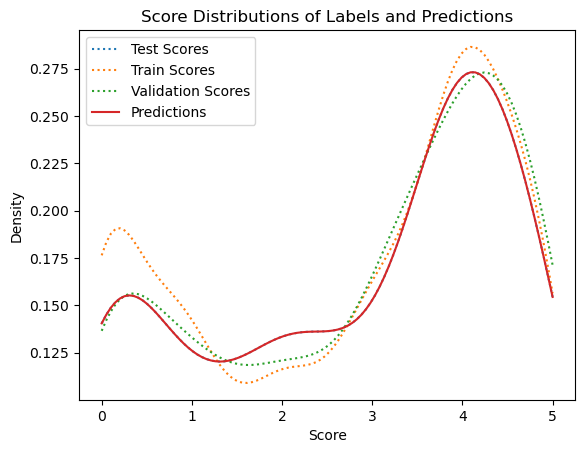

In [17]:
def comp_kde(ds: List[InputExample], xs: np.ndarray):
    kde = stats.gaussian_kde([ex.label*5 for ex in ds])
    return [kde(x) for x in xs]

xs = np.linspace(0, 5, 100)
score_kde = stats.gaussian_kde(df.scores)
plt.plot(xs, [score_kde(x) for x in xs],
         label="Test Scores", linestyle="dotted")
plt.plot(xs, comp_kde(train, xs),
         label="Train Scores", linestyle="dotted")
plt.plot(xs, comp_kde(valid, xs),
         label="Validation Scores", linestyle="dotted")
plt.plot(xs, comp_kde(test, xs),
         label="Predictions", linewidth=1.5)
plt.title("Score Distributions of Labels and Predictions")
plt.xlabel("Score")
plt.ylabel("Density")
plt.legend()

In [23]:
to_latex(df.head(10))

\begin{tabular}{|m{5cm}|m{5cm}|m{1.45cm}|m{1.45cm}|}
    \hline
    Sentence1 & Sentence2 & Score & Prediction \\
    \hline\hline
	the act of substituting one thing for another & the act of contacting one thing with another. &  0.80 &  3.44\\
	\hline
	geography as defined by its use. & a district that has been developed to serve some purpose; &  2.40 &  0.05\\
	\hline
	intuitions, a hunch or feeling & maintain (a theory, thoughts, or feelings). &  1.40 &  3.73\\
	\hline
	an agent or entity becomes sufficient enough to meet a standard. alternatively, an action or occurrence can be thought of as event that fulfills a standard. in this frame, the agent, entity, or event can be conceptualized as being on a scale where a change of value or circumstances brings it in line with the position of the standard on the scale. & fill or meet a want or need &  1.20 &  3.32\\
	\hline
	the act of substituting one thing for another & the act of adding one thing to another. &  1.40 &  3.41\\
	\hline
	Ca